In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

demo = r"D:\Ironhack\project\Project-2-Vanguard-CX-Team\Data\Raw Data\df_final_demo.txt"
exp = r"D:\Ironhack\project\Project-2-Vanguard-CX-Team\Data\Raw Data\df_final_experiment_clients.txt"
webdata1 = r"D:\Ironhack\project\Project-2-Vanguard-CX-Team\Data\Raw Data\df_final_web_data_pt_1.txt"
webdata2 = r"D:\Ironhack\project\Project-2-Vanguard-CX-Team\Data\Raw Data\df_final_web_data_pt_2.txt"
merged = r"D:\Ironhack\project\Project-2-Vanguard-CX-Team\Data\Clean Data\merged_data_with_NaN.csv"
analysis = r"D:\Ironhack\project\Project-2-Vanguard-CX-Team\Data\Clean Data\analysis.csv"


exp_df = pd.read_csv(exp)
demo_df = pd.read_csv(demo)
webdata1_df = pd.read_csv(webdata1)
webdata2_df = pd.read_csv(webdata2)
merged_df = pd.read_csv(merged)
analysis_df = pd.read_csv(analysis)

C:\Users\vgold\AppData\Local\Temp\ipykernel_12716\2214926389.py:19: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(merged)


Total Clients:
Variation
Control    23532
Test       26968
Name: client_id, dtype: int64

Clients Who Completed:
Variation
Control    15434
Test       18687
Name: client_id, dtype: int64

COMPLETION RATE:
  Control     :  65.59%
  Test        :  69.29%

🎯 IMPROVEMENT:
  Absolute: +3.70 percentage points
  Relative: +5.64%
  ✅ Test group shows HIGHER completion rate

KPI 2: TIME SPENT ON EACH STEP
Definition: Average duration users spend on each step

📊 AVERAGE TIME PER STEP (minutes):
                        mean  median  count
Variation process_step                     
Control   confirm       2.15    1.22  16570
          start         2.73    0.85  14455
          step_1        0.72    0.30  29258
          step_2        0.65    0.33  25659
          step_3        1.57    1.10  22329
Test      confirm       2.13    0.95  22204
          start         2.43    0.95  22694
          step_1        0.63    0.18  38346
          step_2        0.80    0.42  30728
          step_3        1.

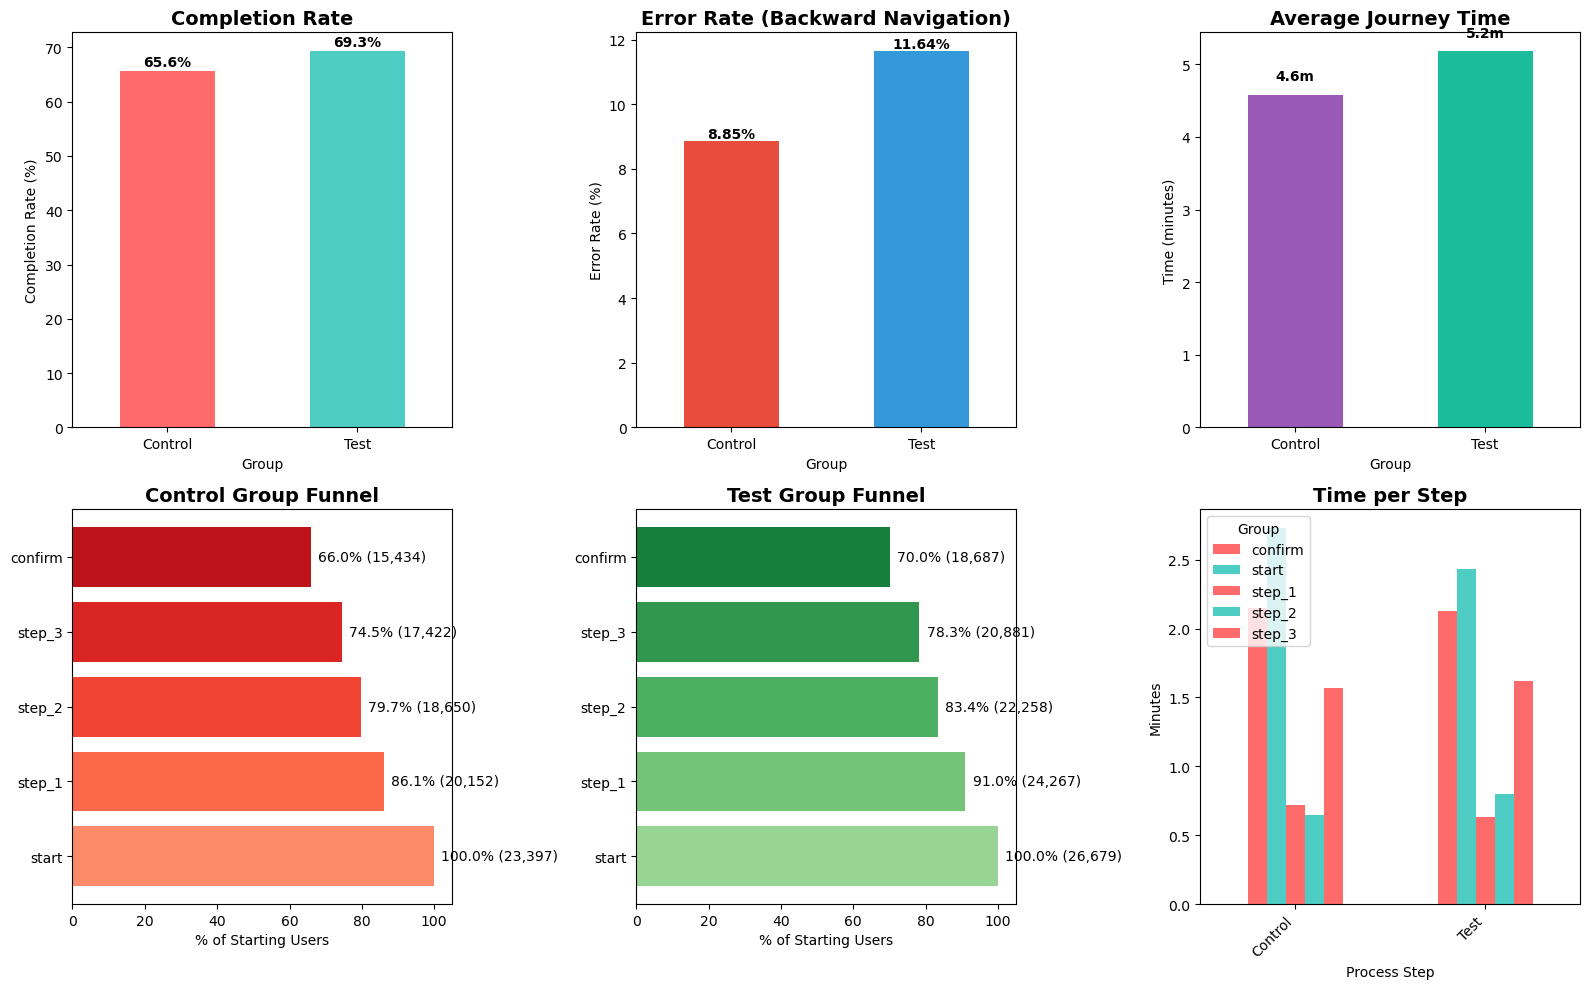


✅ KPI ANALYSIS COMPLETE!

You now have:
  • 6 Key Performance Indicators calculated
  • Control vs Test comparison
  • Executive summary with recommendations
  • Comprehensive visualization dashboard


In [ ]:
print("KPI 1: COMPLETION RATE")
print("Definition: Proportion of users who reach the final 'confirm' step\n")

# Count total unique clients per variation 
total_clients = analysis_df.groupby('Variation')['client_id'].nunique()

#Count clients who reached 'confirmed' step 
completed_clients = analysis_df[analysis_df['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()

#calculate completion rate
completion_rate = (completed_clients / total_clients * 100).round(2)

# Display results
print("Total Clients:")
print(total_clients)
print("\nClients Who Completed:")
print(completed_clients)
print("\nCOMPLETION RATE:")
for var in completion_rate.index:
    print(f"  {var:12s}: {completion_rate[var]:6.2f}%")

# Calculate improvement
if 'Test' in completion_rate.index and 'Control' in completion_rate.index:
    abs_diff = completion_rate['Test'] - completion_rate['Control']
    rel_diff = ((completion_rate['Test'] / completion_rate['Control']) - 1) * 100
    
    print(f"\n🎯 IMPROVEMENT:")
    print(f"  Absolute: {abs_diff:+.2f} percentage points")
    print(f"  Relative: {rel_diff:+.2f}%")
    
    if abs_diff > 0:
        print(f"  ✅ Test group shows HIGHER completion rate")
    elif abs_diff < 0:
        print(f"  ❌ Test group shows LOWER completion rate")
    else:
        print(f"  ➖ No difference in completion rate")




# ============================================================================
# KPI 2: TIME SPENT ON EACH STEP
# ============================================================================

print("\n" + "="*80)
print("KPI 2: TIME SPENT ON EACH STEP")
print("="*80)
print("Definition: Average duration users spend on each step\n")

# Sort data by client, visit, and timestamp
df_sorted = analysis_df.sort_values(['client_id', 'visit_id', 'date_time']).copy()

# Calculate time difference between consecutive steps within same visit
df_sorted['time_diff'] = df_sorted.groupby(['client_id', 'visit_id'])['date_time'].diff()

# Convert to seconds then minutes
df_sorted['time_diff_seconds'] = df_sorted['time_diff'].dt.total_seconds()
df_sorted['time_diff_minutes'] = df_sorted['time_diff_seconds'] / 60

# Filter outliers: Remove sessions > 60 minutes (likely abandoned/interrupted)
df_sorted.loc[df_sorted['time_diff_minutes'] > 60, 'time_diff_minutes'] = np.nan

# Calculate average time per step by variation
time_per_step = df_sorted.groupby(['Variation', 'process_step'])['time_diff_minutes'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('count', 'count')
]).round(2)

print("📊 AVERAGE TIME PER STEP (minutes):")
print(time_per_step)


# Calculate total journey time
total_journey = df_sorted.groupby(['Variation', 'client_id', 'visit_id'])['time_diff_minutes'].sum()
avg_total_time = total_journey.groupby('Variation').agg(['mean', 'median', 'std']).round(2)

print("\n📊 AVERAGE TOTAL JOURNEY TIME (minutes):")
print(avg_total_time)

# Compare Control vs Test
if 'Test' in avg_total_time.index and 'Control' in avg_total_time.index:
    time_diff = avg_total_time.loc['Test', 'mean'] - avg_total_time.loc['Control', 'mean']
    time_pct = (time_diff / avg_total_time.loc['Control', 'mean']) * 100
    
    print(f"\n🎯 JOURNEY TIME COMPARISON:")
    print(f"  Difference: {time_diff:+.2f} minutes ({time_pct:+.1f}%)")
    if time_diff < 0:
        print(f"  ✅ Test group is FASTER")
    elif time_diff > 0:
        print(f"  ❌ Test group is SLOWER")
    else:
        print(f"  ➖ No time difference")


# ============================================================================
# KPI 3: ERROR RATE (Backward Navigation)
# ============================================================================

print("\n" + "="*80)
print("KPI 3: ERROR RATE (Backward Navigation)")
print("="*80)
print("Definition: Moving from a later step to an earlier step indicates confusion\n")

# Define step order
step_order = {
    'start': 0,
    'step_1': 1,
    'step_2': 2,
    'step_3': 3,
    'confirm': 4
}

# Map steps to numbers
df_sorted['step_number'] = df_sorted['process_step'].map(step_order)

# Calculate step change (difference between consecutive steps)
df_sorted['step_change'] = df_sorted.groupby(['client_id', 'visit_id'])['step_number'].diff()

# Identify backward navigation (negative step change = error)
df_sorted['is_backward'] = df_sorted['step_change'] < 0

# Calculate error rate by variation
total_transitions = df_sorted[df_sorted['step_change'].notna()].groupby('Variation').size()
backward_transitions = df_sorted[df_sorted['is_backward'] == True].groupby('Variation').size()
error_rate = (backward_transitions / total_transitions * 100).round(2)

print("📊 STEP TRANSITIONS:")
print(f"Total transitions:")
print(total_transitions)
print(f"\nBackward navigations (errors):")
print(backward_transitions)

print("\n📊 ERROR RATE:")
for var in error_rate.index:
    print(f"  {var:12s}: {error_rate[var]:6.2f}%")

# Calculate improvement
if 'Test' in error_rate.index and 'Control' in error_rate.index:
    error_diff = error_rate['Test'] - error_rate['Control']
    
    print(f"\n🎯 ERROR RATE COMPARISON:")
    print(f"  Difference: {error_diff:+.2f} percentage points")
    if error_diff < 0:
        print(f"  ✅ Test group has FEWER errors")
    elif error_diff > 0:
        print(f"  ❌ Test group has MORE errors")
    else:
        print(f"  ➖ No difference in error rate")

# Show where errors happen most
print("\n📊 ERRORS BY STEP:")
errors_by_step = df_sorted[df_sorted['is_backward'] == True].groupby(['Variation', 'process_step']).size()
print(errors_by_step)

#============================================================================
# KPI 4: DROP-OFF RATE (Additional Important KPI)
# ============================================================================

print("\n" + "="*80)
print("KPI 4: DROP-OFF RATE (Additional KPI)")
print("="*80)
print("Definition: % of users who don't proceed to the next step\n")

# Count users at each step
users_per_step = analysis_df.groupby(['Variation', 'process_step'])['client_id'].nunique().unstack(fill_value=0)

print("📊 USERS AT EACH STEP:")
print(users_per_step)

# Calculate drop-off between consecutive steps
steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

print("\n📊 DROP-OFF RATES:")
for var in users_per_step.index:
    print(f"\n{var} Group:")
    for i in range(len(steps) - 1):
        current = steps[i]
        next_step = steps[i + 1]
        
        if current in users_per_step.columns and next_step in users_per_step.columns:
            current_users = users_per_step.loc[var, current]
            next_users = users_per_step.loc[var, next_step]
            
            if current_users > 0:
                drop_rate = ((current_users - next_users) / current_users * 100)
                retention_rate = (next_users / current_users * 100)
                print(f"  {current:8s} → {next_step:8s}: {drop_rate:5.1f}% drop-off ({retention_rate:5.1f}% retained)")



# ============================================================================
# KPI 5: ENGAGEMENT DEPTH (Additional KPI)
# ============================================================================

print("\n" + "="*80)
print("KPI 5: ENGAGEMENT DEPTH (Additional KPI)")
print("="*80)
print("Definition: How far users progress through the funnel\n")

# Calculate max step reached per client
max_step = df_sorted.groupby(['Variation', 'client_id'])['step_number'].max()
avg_max_step = max_step.groupby('Variation').agg(['mean', 'median']).round(2)

print("📊 AVERAGE MAX STEP REACHED (0=start, 4=confirm):")
print(avg_max_step)

# Step distribution
step_distribution = (max_step.groupby(['Variation', max_step]).size() / 
                     max_step.groupby('Variation').size() * 100).unstack(fill_value=0).round(1)

print("\n📊 DISTRIBUTION OF MAX STEP REACHED (%):")
print(step_distribution)


# ============================================================================
# KPI 6: VISIT EFFICIENCY (Additional KPI)
# ============================================================================

print("\n" + "="*80)
print("KPI 6: VISIT EFFICIENCY (Additional KPI)")
print("="*80)
print("Definition: Average number of visits needed per client\n")

visits_per_client = analysis_df.groupby(['Variation', 'client_id'])['visit_id'].nunique()
avg_visits = visits_per_client.groupby('Variation').agg(['mean', 'median', 'std']).round(2)

print("📊 AVERAGE VISITS PER CLIENT:")
print(avg_visits)


# ============================================================================
# COMPREHENSIVE KPI SUMMARY TABLE
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE KPI SUMMARY")
print("="*80)

# Create summary DataFrame
kpi_summary = pd.DataFrame({
    'Completion Rate (%)': completion_rate,
    'Avg Journey Time (min)': avg_total_time['mean'],
    'Error Rate (%)': error_rate,
    'Avg Max Step (0-4)': avg_max_step['mean'],
    'Avg Visits per Client': avg_visits['mean']
})

print("\n" + kpi_summary.to_string())

# Calculate improvements (Test vs Control)
if 'Test' in kpi_summary.index and 'Control' in kpi_summary.index:
    print("\n" + "="*80)
    print("🎯 TEST vs CONTROL COMPARISON (Improvement)")
    print("="*80)
    
    improvements = pd.DataFrame({
        'Control': kpi_summary.loc['Control'],
        'Test': kpi_summary.loc['Test'],
        'Absolute Diff': kpi_summary.loc['Test'] - kpi_summary.loc['Control'],
        'Relative Diff (%)': ((kpi_summary.loc['Test'] / kpi_summary.loc['Control']) - 1) * 100
    })
    
    print("\n" + improvements.round(2).to_string())


# ============================================================================
# REDESIGN OUTCOME - FINAL VERDICT
# ============================================================================

print("\n" + "="*80)
print("REDESIGN OUTCOME - EXECUTIVE SUMMARY")
print("="*80)

if 'Test' in completion_rate.index and 'Control' in completion_rate.index:
    
    print("\n🎯 KEY FINDINGS:\n")
    
    # 1. Completion Rate
    cr_change = completion_rate['Test'] - completion_rate['Control']
    print(f"1️⃣  COMPLETION RATE:")
    print(f"    Control: {completion_rate['Control']:.2f}% | Test: {completion_rate['Test']:.2f}%")
    print(f"    Change: {cr_change:+.2f} pp → ", end="")
    if cr_change > 2:
        print("✅ SIGNIFICANT IMPROVEMENT")
    elif cr_change > 0:
        print("✅ Slight improvement")
    elif cr_change > -2:
        print("➖ Minimal change")
    else:
        print("❌ Decline")
    
    # 2. Error Rate
    er_change = error_rate.get('Test', 0) - error_rate.get('Control', 0)
    print(f"\n2️⃣  ERROR RATE:")
    print(f"    Control: {error_rate.get('Control', 0):.2f}% | Test: {error_rate.get('Test', 0):.2f}%")
    print(f"    Change: {er_change:+.2f} pp → ", end="")
    if er_change < -0.5:
        print("✅ FEWER ERRORS")
    elif er_change <= 0:
        print("✅ Slight reduction")
    elif er_change < 0.5:
        print("➖ Minimal change")
    else:
        print("❌ More errors")
    
    # 3. Journey Time
    jt_change = avg_total_time.loc['Test', 'mean'] - avg_total_time.loc['Control', 'mean']
    jt_pct = (jt_change / avg_total_time.loc['Control', 'mean']) * 100
    print(f"\n3️⃣  JOURNEY TIME:")
    print(f"    Control: {avg_total_time.loc['Control', 'mean']:.2f} min | Test: {avg_total_time.loc['Test', 'mean']:.2f} min")
    print(f"    Change: {jt_change:+.2f} min ({jt_pct:+.1f}%) → ", end="")
    if jt_change < -1:
        print("✅ FASTER")
    elif jt_change <= 0:
        print("✅ Slightly faster")
    elif jt_change < 1:
        print("➖ Minimal change")
    else:
        print("❌ Slower")
    
    # Overall verdict
    print("\n" + "-"*80)
    print("🏆 OVERALL VERDICT:")
    print("-"*80)
    
    positive_count = sum([
        cr_change > 0,
        er_change < 0,
        jt_change < 0
    ])
    
    if positive_count >= 2:
        print("✅ The NEW DESIGN shows POSITIVE results")
        print("   Recommendation: IMPLEMENT the new design")
    elif positive_count == 1:
        print("⚠️  The new design shows MIXED results")
        print("   Recommendation: Further analysis or iteration needed")
    else:
        print("❌ The new design shows NEGATIVE results")
        print("   Recommendation: DO NOT implement; redesign required")


# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create figure with subplots
fig = plt.figure(figsize=(16, 10))

# 1. Completion Rate Comparison
ax1 = plt.subplot(2, 3, 1)
completion_rate.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Completion Rate', fontsize=14, fontweight='bold')
ax1.set_ylabel('Completion Rate (%)')
ax1.set_xlabel('Group')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
for i, v in enumerate(completion_rate.values):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 2. Error Rate Comparison
ax2 = plt.subplot(2, 3, 2)
error_rate.plot(kind='bar', ax=ax2, color=['#E74C3C', '#3498DB'])
ax2.set_title('Error Rate (Backward Navigation)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Error Rate (%)')
ax2.set_xlabel('Group')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
for i, v in enumerate(error_rate.values):
    ax2.text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

# 3. Journey Time Comparison
ax3 = plt.subplot(2, 3, 3)
avg_total_time['mean'].plot(kind='bar', ax=ax3, color=['#9B59B6', '#1ABC9C'])
ax3.set_title('Average Journey Time', fontsize=14, fontweight='bold')
ax3.set_ylabel('Time (minutes)')
ax3.set_xlabel('Group')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
for i, v in enumerate(avg_total_time['mean'].values):
    ax3.text(i, v + 0.2, f'{v:.1f}m', ha='center', fontweight='bold')

# 4. Funnel - Control
ax4 = plt.subplot(2, 3, 4)
if 'Control' in users_per_step.index:
    control_funnel = [users_per_step.loc['Control', step] if step in users_per_step.columns else 0 
                      for step in steps]
    control_pct = [v/control_funnel[0]*100 if control_funnel[0] > 0 else 0 for v in control_funnel]
    
    ax4.barh(steps, control_pct, color=plt.cm.Reds(np.linspace(0.4, 0.8, len(steps))))
    ax4.set_xlim([0, 105])
    ax4.set_xlabel('% of Starting Users')
    ax4.set_title('Control Group Funnel', fontsize=14, fontweight='bold')
    for i, (s, p, c) in enumerate(zip(steps, control_pct, control_funnel)):
        ax4.text(p + 2, i, f'{p:.1f}% ({c:,})', va='center')

# 5. Funnel - Test
ax5 = plt.subplot(2, 3, 5)
if 'Test' in users_per_step.index:
    test_funnel = [users_per_step.loc['Test', step] if step in users_per_step.columns else 0 
                   for step in steps]
    test_pct = [v/test_funnel[0]*100 if test_funnel[0] > 0 else 0 for v in test_funnel]
    
    ax5.barh(steps, test_pct, color=plt.cm.Greens(np.linspace(0.4, 0.8, len(steps))))
    ax5.set_xlim([0, 105])
    ax5.set_xlabel('% of Starting Users')
    ax5.set_title('Test Group Funnel', fontsize=14, fontweight='bold')
    for i, (s, p, c) in enumerate(zip(steps, test_pct, test_funnel)):
        ax5.text(p + 2, i, f'{p:.1f}% ({c:,})', va='center')

# 6. Time per Step Comparison
ax6 = plt.subplot(2, 3, 6)
time_comparison = time_per_step['mean'].unstack()
if not time_comparison.empty:
    time_comparison.plot(kind='bar', ax=ax6, color=['#FF6B6B', '#4ECDC4'])
    ax6.set_title('Time per Step', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Minutes')
    ax6.set_xlabel('Process Step')
    ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
    ax6.legend(title='Group', loc='upper left')

plt.tight_layout()
plt.savefig('D:\Ironhack\project/vanguard_kpi_dashboard.png', dpi=300, bbox_inches='tight')
print("\n✅ Dashboard saved as: vanguard_kpi_dashboard.png")
plt.show()

print("\n" + "="*80)
print("✅ KPI ANALYSIS COMPLETE!")
print("="*80)
print("\nYou now have:")
print("  • 6 Key Performance Indicators calculated")
print("  • Control vs Test comparison")
print("  • Executive summary with recommendations")
print("  • Comprehensive visualization dashboard")
        